### Predicting formation enthalpies for solid solutions of Lanthanides Orthophosphates


In [6]:
import os
import sys
import inspect

print(sys.version)

currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
grandparentdir = os.path.dirname(parentdir)

sys.path.insert(0, grandparentdir) 

3.9.6 (default, Nov 10 2023, 13:38:27) 
[Clang 15.0.0 (clang-1500.1.0.2.5)]


In [7]:
import read_data
import featureSpan
import lasso
import Utils
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.optimize
import pandas as pd
import seaborn as sns
import scipy.stats as ss
from sklearn.linear_model import Lasso
from itertools import combinations, product
import itertools
import math
import pandas as pd

import matplotlib as mpl
from pylab import cm

import matplotlib.font_manager as fm

#plt.style.use('science')

## Xenotime + Monazite

#### Load data from files

In [8]:
list1M = read_data.readData("../../data/DATA_HE_monazite.dat")
print("Shape of List1M is {}".format(list1M.shape))
print(list1M)

Shape of List1M is (525, 4)
[[5.70000000e+01 5.80000000e+01 7.50000000e-01 1.29717527e-01]
 [5.70000000e+01 5.80000000e+01 6.25000000e-01 1.90974365e-01]
 [5.70000000e+01 5.80000000e+01 5.00000000e-01 1.92712564e-01]
 ...
 [7.00000000e+01 7.10000000e+01 5.00000000e-01 2.12444086e-02]
 [7.00000000e+01 7.10000000e+01 3.75000000e-01 2.22639048e-02]
 [7.00000000e+01 7.10000000e+01 2.50000000e-01 2.09098752e-02]]


In [9]:
list2M = read_data.readCSVData("../../data/Data_Ln-monazite.csv", Volume=True)
print("Shape of List2M is {}".format(list2M.shape))
print((list2M))

Shape of List2M is (15, 9)
[[ 57.         138.90547     19.1773     139.1         11.
    1.1         49.95        77.61001595   1.216     ]
 [ 58.         140.116       20.198      146.5         12.
    1.12        36.758       75.78168414   1.196     ]
 [ 59.         140.90765     21.624      150.1         12.3
    1.13        38.98        74.20076494   1.179     ]
 [ 60.         144.242       22.1        154.1         12.95
    1.14        40.41        72.98174154   1.163     ]
 [ 61.         145.          22.3        157.4         13.6
    1.13        41.1         71.90916336   1.144     ]
 [ 62.         150.36        23.4        160.3         14.25
    1.17        41.4         70.88675537   1.132     ]
 [ 63.         151.964       24.92       163.1         14.9
    1.2         42.7         70.00137871   1.12      ]
 [ 64.         157.25        20.63       165.2         15.9
    1.2         44.          69.15236746   1.107     ]
 [ 65.         158.92535     21.91       164.5       

In [10]:
list1X = read_data.readData("../../data/DATA_HE_xenotime.dat")
print("Shape of List1X is {}".format(list1X.shape))
print(list1X)

Shape of List1X is (525, 4)
[[5.70000000e+01 5.80000000e+01 7.50000000e-01 2.31598225e-01]
 [5.70000000e+01 5.80000000e+01 6.25000000e-01 2.78958493e-01]
 [5.70000000e+01 5.80000000e+01 5.00000000e-01 2.97583757e-01]
 ...
 [7.00000000e+01 7.10000000e+01 5.00000000e-01 7.77590152e-02]
 [7.00000000e+01 7.10000000e+01 3.75000000e-01 7.09266168e-02]
 [7.00000000e+01 7.10000000e+01 2.50000000e-01 5.91211365e-02]]


In [11]:
list2X = read_data.readCSVData("../../data/Data_Ln-xenotime.csv", material = "xenotime", Volume=True)
print("Shape of List2X is {}".format(list2X.shape))
print((list2X))

Shape of List2X is (15, 9)
[[ 57.         138.90547     19.1773      91.7         11.
    1.1         49.95        83.16086967   1.16      ]
 [ 58.         140.116       20.198       99.73        12.
    1.12        36.758       81.11579575   1.143     ]
 [ 59.         140.90765     21.624      112.27        12.3
    1.13        38.98        79.31176899   1.126     ]
 [ 60.         144.242       22.1        120.19        12.95
    1.14        40.41        77.89975607   1.109     ]
 [ 61.         145.          22.3        127.26        13.6
    1.13        41.1         76.63526873   1.093     ]
 [ 62.         150.36        23.4        137.16        14.25
    1.17        41.4         75.42961529   1.079     ]
 [ 63.         151.964       24.92       143.83        14.9
    1.2         42.7         74.36126731   1.066     ]
 [ 64.         157.25        20.63       149.42        15.9
    1.2         44.          73.33463097   1.053     ]
 [ 65.         158.92535     21.91       156.33      

#### Generated Elemental Training/Testing sets from loaded data

In [12]:
def generateFeatures_full2(HEList, featureList):
    X = []
    Y = []
    
    for i in range(len(HEList)):
        Y.append(HEList[i][3])
        
        x = HEList[i][2]
        X1 = featureList[int(HEList[i][0]-57)]
        X2 = featureList[int(HEList[i][1]-57)]

        #X.append(np.concatenate((np.array([x, 1/x, x * x, 1 / (x * x), 1-x, 1/(1-x), (1-x) * (1-x), 1/( (1-x) * (1-x))]), np.array([abs(X1-X2)/2.0, 2.0 / (abs(X1-X2)), (X1 + X2) / 2.0, 2.0 / (X1 + X2)]).flatten())))
        mfeatures = np.array([x, 1/x, x * x, 1 / (x * x), 1-x, 1/(1-x), (1-x) * (1-x), 1/( (1-x) * (1-x))])
        
        f1 = []
        f2 = []
        f3 = []
        f4 = []
        
        for j in range(len(X1)-4):
            f1.append([abs(X1[j]-X2[j])/2.0])
            f2.append([2.0/abs(X1[j]-X2[j])])
            f3.append([(X1[j] + X2[j]) / 2.0])
            f4.append([2.0 / (X1[j] + X2[j])])
            
        #rint(f3)
        #print(np.asarray(f3).flatten())
    
        #print(np.concatenate((mfeatures, np.asarray(f1).flatten(), np.asarray(f3).flatten())))
              
        f5 = []
        f6 = []
        f7 = []
        
        for j in range(5,7):
            f5.append([abs(X1[j]-X2[j])/2.0])
            f6.append([(X1[j] + X2[j]) / 2.0])
            f7.append([2.0 / (X1[j] + X2[j])])            
            
        f8 = []
        f9 = []
        f10 = []
        f11 = []
        f12 = []
        f13 = []
        f14 = []
        f15 = []
        f16 = []
        f17 = []
        f18 = []
        f19 = []
        
  
        for j in range(7,len(X1)):
            f8.append([abs(X1[j]-X2[j])/2.0])
            f9.append([2.0/abs(X1[j]-X2[j])])
            f10.append([(X1[j] + X2[j]) / 2.0])
            f11.append([2.0 / (X1[j] + X2[j])])
            f12.append([pow(abs(X1[j]-X2[j])/2.0,2)])
            f13.append([pow(2.0/abs(X1[j]-X2[j]),2)])
            f14.append([pow((X1[j] + X2[j]) / 2.0,2)])
            f15.append([pow(2.0 / (X1[j] + X2[j]),2)])
            f16.append([pow(abs(X1[j]-X2[j])/2.0,3)])
            f17.append([pow(2.0/abs(X1[j]-X2[j]),3)])
            f18.append([pow((X1[j] + X2[j]) / 2.0,3)])
            f19.append([pow(2.0 / (X1[j] + X2[j]),3)])
            
        
        X.append(np.concatenate((mfeatures, np.asarray(f1).flatten(),  np.asarray(f2).flatten(),  np.asarray(f3).flatten(), np.asarray(f4).flatten(), np.asarray(f5).flatten(), np.asarray(f6).flatten(),np.asarray(f7).flatten(),np.asarray(f8).flatten(),np.asarray(f9).flatten(),np.asarray(f10).flatten(),np.asarray(f11).flatten(),np.asarray(f12).flatten(),np.asarray(f13).flatten(),np.asarray(f14).flatten(),np.asarray(f15).flatten(),np.asarray(f16).flatten(),np.asarray(f17).flatten(),np.asarray(f18).flatten(),np.asarray(f19).flatten()     )))
            
    return X, Y

In [13]:
listXM, listYM = generateFeatures_full2(list1M, list2M)
XM = np.asarray(listXM)
YM = np.asarray(listYM)
print(XM.shape)
print(YM.shape)

listXX, listYX = generateFeatures_full2(list1X, list2X)
XX = np.asarray(listXX)
YX = np.asarray(listYX)
print(XM.shape)
print(YM.shape)

X = np.concatenate((XM, XX), axis=0)
Y = np.concatenate((YM, YX), axis=0)
print(X.shape)
print(Y.shape)

elemental_list = ["m", "1/m", "m^2", "(1/m)^2", "(1-m)", "1/(1-m)", "(1-m)^2", "(1/(1-m))^2", "[AD:Z]", "[AD:M]", "[AD:IP2]", "[AD:Young]", "[AD:Charge]",  "(1/[AD:Z])", "(1/[AD:M])", "(1/[AD:IP2])", "(1/[AD:Young])", "(1/[AD:Charge])",  "[AM:Z]", "[AM:M]", "[AM:IP2]", "[AM:Young]", "[AM:Charge]",  "(1/[AM:Z])", "(1/[AM:M])", "(1/[AM:IP2])", "(1/[AM:Young])", "(1/[AM:Charge])", "[AD:electronegativity]", "[AD:IP3]", "[AM:electronegativity]", "[AM:IP3]","(1/[AM:electronegativity])", "(1/[AM:IP3])" ,    "[AD:Vol]", "[AD:R]", "(1/[AD:Vol])", "(1/[AD:R])" , "[AM:Vol]", "[AM:R]","(1/[AM:Vol])", "(1/[AM:R])",   "([AD:Vol])^2", "([AD:R])^2", "(1/[AD:Vol])^2", "(1/[AD:R])^2" , "([AM:Vol])^2", "([AM:R])^2","(1/[AM:Vol])^2", "(1/[AM:R])^2",    "([AD:Vol])^3", "([AD:R])^3", "(1/[AD:Vol])^3", "(1/[AD:R])^3" , "([AM:Vol])^3", "([AM:R])^3","(1/[AM:Vol])^3", "(1/[AM:R])^3"         ]
print(len(elemental_list))
print(elemental_list)
m, n = X.shape

elemental_features = []

for i in elemental_list:
    elemental_features.append("("+i+")")
        
print("The elemental features are: \n {}".format(elemental_features))

(525, 58)
(525,)
(525, 58)
(525,)
(1050, 58)
(1050,)
58
['m', '1/m', 'm^2', '(1/m)^2', '(1-m)', '1/(1-m)', '(1-m)^2', '(1/(1-m))^2', '[AD:Z]', '[AD:M]', '[AD:IP2]', '[AD:Young]', '[AD:Charge]', '(1/[AD:Z])', '(1/[AD:M])', '(1/[AD:IP2])', '(1/[AD:Young])', '(1/[AD:Charge])', '[AM:Z]', '[AM:M]', '[AM:IP2]', '[AM:Young]', '[AM:Charge]', '(1/[AM:Z])', '(1/[AM:M])', '(1/[AM:IP2])', '(1/[AM:Young])', '(1/[AM:Charge])', '[AD:electronegativity]', '[AD:IP3]', '[AM:electronegativity]', '[AM:IP3]', '(1/[AM:electronegativity])', '(1/[AM:IP3])', '[AD:Vol]', '[AD:R]', '(1/[AD:Vol])', '(1/[AD:R])', '[AM:Vol]', '[AM:R]', '(1/[AM:Vol])', '(1/[AM:R])', '([AD:Vol])^2', '([AD:R])^2', '(1/[AD:Vol])^2', '(1/[AD:R])^2', '([AM:Vol])^2', '([AM:R])^2', '(1/[AM:Vol])^2', '(1/[AM:R])^2', '([AD:Vol])^3', '([AD:R])^3', '(1/[AD:Vol])^3', '(1/[AD:R])^3', '([AM:Vol])^3', '([AM:R])^3', '(1/[AM:Vol])^3', '(1/[AM:R])^3']
The elemental features are: 
 ['(m)', '(1/m)', '(m^2)', '((1/m)^2)', '((1-m))', '(1/(1-m))', '((1-m)^

In [14]:
dfX = pd.DataFrame(data=X, columns=elemental_features)

new_features=[]
new_columns = []

cnt = 0

for i in range(n):
    for j in range(i):
        new_features.append(elemental_features[i]+"*"+elemental_features[j])
        new_columns.append(dfX[elemental_features[i]].values * dfX[elemental_features[j]].values)
        cnt = cnt + 1

print(cnt)

cnt = 0

for i in range(n):
    for j in range(i):
        for k in range(j):
            new_features.append(elemental_features[i]+"*"+elemental_features[j]+"*"+elemental_features[k])
            new_columns.append(dfX[elemental_features[i]] * dfX[elemental_features[j]] * dfX[elemental_features[k]])
            cnt = cnt + 1
            
print(cnt)
            
new_columns = np.asarray(new_columns)
dfX = pd.concat(
    [
        dfX,
        pd.DataFrame(
            new_columns.T, 
            index=dfX.index, 
            columns=new_features
        )
    ], axis=1
)

dfX.head()



#dfX2=dfX.loc[:, dfX.std() <= 0]
#dfX2.head()

dfX.std() == 0
dfX=dfX.loc[:, dfX.std() > 0]
dfX.head()


1653
30856


,(m),(1/m),(m^2),((1/m)^2),((1-m)),(1/(1-m)),((1-m)^2),((1/(1-m))^2),([AD:Z]),([AD:M]),...,((1/[AM:R])^3)*((1/[AM:Vol])^3)*(([AM:Vol])^2),((1/[AM:R])^3)*((1/[AM:Vol])^3)*(([AM:R])^2),((1/[AM:R])^3)*((1/[AM:Vol])^3)*((1/[AM:Vol])^2),((1/[AM:R])^3)*((1/[AM:Vol])^3)*((1/[AM:R])^2),((1/[AM:R])^3)*((1/[AM:Vol])^3)*(([AD:Vol])^3),((1/[AM:R])^3)*((1/[AM:Vol])^3)*(([AD:R])^3),((1/[AM:R])^3)*((1/[AM:Vol])^3)*((1/[AD:Vol])^3),((1/[AM:R])^3)*((1/[AM:Vol])^3)*((1/[AD:R])^3),((1/[AM:R])^3)*((1/[AM:Vol])^3)*(([AM:Vol])^3),((1/[AM:R])^3)*((1/[AM:Vol])^3)*(([AM:R])^3)
0,0.750,1.333333,0.562500,1.777778,0.250,4.000000,0.062500,16.000000,0.5,0.605265,...,0.007433,0.000002,2.148319e-10,8.688561e-07,9.654228e-07,1.263696e-12,0.000002,1.263696,0.570109,0.000002
1,0.625,1.600000,0.390625,2.560000,0.375,2.666667,0.140625,7.111111,0.5,0.605265,...,0.007433,0.000002,2.148319e-10,8.688561e-07,9.654228e-07,1.263696e-12,0.000002,1.263696,0.570109,0.000002
2,0.500,2.000000,0.250000,4.000000,0.500,2.000000,0.250000,4.000000,0.5,0.605265,...,0.007433,0.000002,2.148319e-10,8.688561e-07,9.654228e-07,1.263696e-12,0.000002,1.263696,0.570109,0.000002
3,0.375,2.666667,0.140625,7.111111,0.625,1.600000,0.390625,2.560000,0.5,0.605265,...,0.007433,0.000002,2.148319e-10,8.688561e-07,9.654228e-07,1.263696e-12,0.000002,1.263696,0.570109,0.000002
4,0.250,4.000000,0.062500,16.000000,0.750,1.333333,0.562500,1.777778,0.5,0.605265,...,0.007433,0.000002,2.148319e-10,8.688561e-07,9.654228e-07,1.263696e-12,0.000002,1.263696,0.570109,0.000002


In [15]:
print(len(dfX.columns.values))
np.array(dfX.columns.values)

32561


array(['(m)', '(1/m)', '(m^2)', ...,
       '((1/[AM:R])^3)*((1/[AM:Vol])^3)*((1/[AD:R])^3)',
       '((1/[AM:R])^3)*((1/[AM:Vol])^3)*(([AM:Vol])^3)',
       '((1/[AM:R])^3)*((1/[AM:Vol])^3)*(([AM:R])^3)'], dtype=object)

In [16]:
def LassoFit(lmb, X, Y, max_iter=100000, standardization = True):
    
    scaler = StandardScaler()
    scaler.fit(X)
    X_standardized = scaler.transform(X)
    lasso =  Lasso(alpha=lmb, max_iter=max_iter)
    lasso.fit(X_standardized, Y.copy())
    coef =  lasso.coef_
    selected_indices = coef.nonzero()[0]
    selected_features = np.array(dfX.columns.values)[selected_indices]
    Y_predict = lasso.predict(X_standardized)
    MAE, MSE, MAPE = Utils.compute_error(Y.copy(), Y_predict)
        
    return coef, selected_indices, selected_features, MAE, MSE, MAPE

LassoFit(0.01, dfX, Y)

(array([ 0., -0.,  0., ...,  0., -0., -0.]),
 array([ 1887,  2922,  3553,  3806,  4382,  4693,  4707,  7695,  7748,
         7976,  8051,  8135,  8149,  8165,  8217,  8247,  8778, 10218,
        12442, 12956, 13202, 13244, 13743, 13872, 13881, 14182, 20720,
        21023, 22004, 22518, 22657, 31853, 31856, 31859, 32183]),
 array(['([AD:Young])*((1-m)^2)*(m^2)',
        '([AM:IP2])*([AD:Charge])*([AD:Young])',
        '((1/[AM:Z]))*([AD:Charge])*([AD:Young])',
        '((1/[AM:M]))*([AD:Charge])*([AD:Young])',
        '((1/[AM:Young]))*([AD:Charge])*([AD:Young])',
        '((1/[AM:Charge]))*([AD:Young])*([AD:Z])',
        '((1/[AM:Charge]))*([AD:Charge])*([AD:Young])',
        '([AD:Vol])*((1-m))*(m)', '([AD:Vol])*([AD:Young])*((1-m))',
        '([AD:Vol])*((1/[AM:M]))*([AD:Young])',
        '([AD:Vol])*((1/[AM:Charge]))*([AD:Young])',
        '([AD:Vol])*([AM:electronegativity])*([AD:Young])',
        '([AD:Vol])*([AM:electronegativity])*((1/[AM:IP2]))',
        '([AD:Vol])*([AM:IP3])*

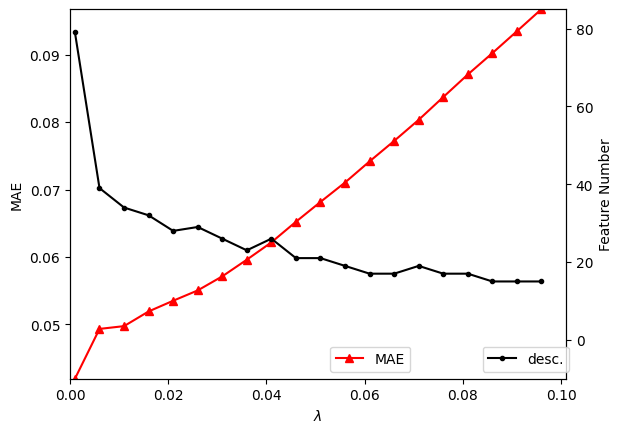

In [18]:
def LassoPlot(X, Y, min, max, step, standardization = True ):
    
    scaler = StandardScaler()
    scaler.fit(X)
    X_standardized = scaler.transform(X)
    
    coefs = []
    indices = []
    MAEs = []
    MSEs = []
    MAPEs = []
    lmbs = []
    nbs = []

    for lmbda in np.arange (min, max, step):
        lmbs.append(np.array(lmbda))
        coef, selected_indices, selected_features, MAE, MSE, MAPE = LassoFit(lmbda, X_standardized, Y)
        coefs.append(np.array(coef))
        indices.append(np.array(selected_indices))
        nbs.append(len(selected_indices))
        MAEs.append(np.array(MAE))
        MSEs.append(np.array(MSE))
        MAPEs.append(np.array(MAPE))
    
    fig, ax = plt.subplots()
    twin = ax.twinx()
    ax.plot(lmbs, MAEs, label='MAE',marker="^", color='red')
    pparam = dict(xlabel='$\lambda$', ylabel='MAE')
    ax.autoscale(tight=True)
    ax.set(**pparam)
    ax.set_xlim(0.0005, max)
    ax.legend(loc='lower right', bbox_to_anchor=(0.7, 0.0))

    twin.plot(lmbs, nbs, label='desc.', color='black', marker=".")
    twin.set_ylabel("Feature Number")
    twin.autoscale(tight=True)
    twin.set_xlim(0, max)
    twin.set_ylim(-10, 85)
    twin.legend(loc='lower right', bbox_to_anchor=(1.02, 0.0))        
    fig.savefig('lasso_new_fused_lassol1.pdf')
    
LassoPlot(dfX, Y, 0.001, 0.101, 0.005)

In [19]:
#### Define a function which fits Lasso to have no more nonzero coefficients than a given threshold 
def LassoSelect(X, Y, min, max, step, threshold, standardization = True):
    
    scaler = StandardScaler()
    scaler.fit(X)
    X_standardized = scaler.transform(X)
        
    found = False
    for lmbda in np.arange (min, max, step):
        coef, selected_indices, selected_features, MAE, MSE, ME = LassoFit(lmbda, X.copy(), Y.copy())
        if len(selected_indices) <= threshold:
            found = True
            break
    
    if found:
        print("FOUND with threshold: {}".format(threshold))
        print("Lambda: {}, nnz: {}, MAE: {}, MSE: {}, ME: {}".format(lmbda, len(selected_indices), MAE, MSE, ME))
            
    else:
        print("NOT FOUND with threshold: {}".format(threshold))
        print("Closest are: ")
        print("Lambda: {}, nnz: {}, MAE: {}, MSE: {}, ME: {}".format(lmbda, len(selected_indices), MAE, MSE, ME))
     
    X_reduced = X[selected_features]
    
    return X_reduced


X_reduced = LassoSelect(dfX, Y, 0.001, 0.101, 0.005, 30)
X_reduced.head()

FOUND with threshold: 30
Lambda: 0.021, nnz: 28, MAE: 0.05351435461561156, MSE: 0.0072846454388948, ME: 0.086359355713397


,([AD:Young])*((1-m)^2)*(m^2),((1/[AM:Z]))*([AD:Charge])*([AD:Young]),((1/[AM:M]))*([AD:Charge])*([AD:Young]),((1/[AM:Young]))*([AD:Charge])*([AD:Young]),((1/[AM:Charge]))*([AD:Young])*([AD:Z]),((1/[AM:Charge]))*([AD:Charge])*([AD:Young]),([AD:Vol])*((1-m))*(m),([AD:Vol])*([AD:Young])*((1-m)),([AD:Vol])*((1/[AM:Charge]))*([AD:Young]),([AD:Vol])*([AM:electronegativity])*([AD:Young]),...,((1/[AM:R])^2)*(([AD:Vol])^2)*((1/[AM:IP3])),((1/[AM:R])^2)*(([AD:Vol])^2)*((1/[AD:R])),(([AD:Vol])^3)*((1/[AD:Vol])^2)*([AD:Young]),(([AD:Vol])^3)*((1/[AM:R])^2)*((1/[AD:R])),(([AM:Vol])^3)*([AD:Charge])*([AD:Young]),((1/[AM:R])^3)*(([AD:Vol])^2)*([AM:electronegativity]),((1/[AM:R])^3)*(([AD:Vol])^2)*((1/[AM:IP3])),((1/[AM:R])^3)*(([AM:Vol])^2)*(([AD:Vol])^2),((1/[AM:R])^3)*((1/[AM:R])^2)*(([AD:Vol])^2),((1/[AM:R])^3)*(([AD:Vol])^3)*((1/[AD:R]))
0,0.130078,0.032174,0.013261,0.012955,0.16087,0.16087,0.171406,0.845603,0.294123,3.754479,...,0.013253,57.458651,3.382414,52.526739,834617.187677,0.528848,0.01099,2802.540161,0.327577,43.55451
1,0.203247,0.032174,0.013261,0.012955,0.16087,0.16087,0.214258,1.268405,0.294123,3.754479,...,0.013253,57.458651,3.382414,52.526739,834617.187677,0.528848,0.01099,2802.540161,0.327577,43.55451
2,0.231250,0.032174,0.013261,0.012955,0.16087,0.16087,0.228541,1.691207,0.294123,3.754479,...,0.013253,57.458651,3.382414,52.526739,834617.187677,0.528848,0.01099,2802.540161,0.327577,43.55451
3,0.203247,0.032174,0.013261,0.012955,0.16087,0.16087,0.214258,2.114009,0.294123,3.754479,...,0.013253,57.458651,3.382414,52.526739,834617.187677,0.528848,0.01099,2802.540161,0.327577,43.55451
4,0.130078,0.032174,0.013261,0.012955,0.16087,0.16087,0.171406,2.536810,0.294123,3.754479,...,0.013253,57.458651,3.382414,52.526739,834617.187677,0.528848,0.01099,2802.540161,0.327577,43.55451


In [20]:
def LassoL0(X, Y, nnz):    
    nr, nc = X.shape
    X = np.column_stack((X, np.ones(nr)))
    se_min = np.inner(Y, Y)
    coef_min, permu_min = None, None
    for permu in combinations(range(nc), nnz):
        X_ls = X[:, permu + (-1,)]
        coef, se, __1, __2 = np.linalg.lstsq(X_ls, Y, rcond=-1)
        try:
            if se[0] < se_min: 
                se_min = se[0]
                coef_min, permu_min = coef, permu
        except:
            pass
        
    return coef_min, permu_min

In [21]:
def LassoL0Fit(X_reduced, Y, nnz, log=True):
    
    scaler = StandardScaler()
    scaler.fit(X_reduced)
    X_std = scaler.transform(X_reduced)
    
    nr, nc = X_reduced.shape
   
    coefficients, selected_indices = LassoL0(X_std, Y, nnz)
   
    coefficients = np.array(coefficients)
    selected_indices = np.array(selected_indices)
    feature_reduced = np.array(X_reduced.columns.values)
    feature_list_selected = feature_reduced[selected_indices]
    
    X_selected = X_reduced[feature_list_selected]

    mean_selected = X_selected.mean()
    std_selected = X_selected.std()

    
    if log:
        print("Lasso: selected coefficients are: {}".format(coefficients))
        print("Lasso: selected features are: {}".format(feature_list_selected))
        
    #-mean/std
    mean_std = []
    for i in range(len(selected_indices)):
        mean_std.append(coefficients[i] * mean_selected[i]/std_selected[i])
 
    sum_mean_std = sum(mean_std)

    for i in range(len(selected_indices)):
        coefficients[i] = coefficients[i] / std_selected[i]

    
    coefficients[len(selected_indices)] -= sum_mean_std
    
    function = str(coefficients[0])+" * "+feature_list_selected[0]
    
    for i in range(1, len(selected_indices)):
        if coefficients[i] >= 0:
            function += " + " + str(coefficients[i])+" * "+feature_list_selected[i]
        else:
            function += " - " + str(abs(coefficients[i]))+" * "+feature_list_selected[i]

    
    if coefficients[len(selected_indices)] >= 0:
        function += " + " + str(coefficients[len(selected_indices)])
    else:
        function += " - " + str(abs(coefficients[len(selected_indices)]))
    
    if log:
        print("Constructed function is: {}".format(function))

    X_selected = np.column_stack((X_selected, np.ones(X_selected.shape[0])))
    Y_predict = X_selected[:,0] * coefficients[0]

    for i in range(1,len(selected_indices)+1):
        Y_predict = Y_predict + X_selected[:,i] * coefficients[i]
    
    if log:
        Utils.print_error(Y.copy(),Y_predict,"Lasso L0: {} coef".format(nnz))
    
    return Y_predict, coefficients, selected_indices

In [22]:
LassoL0Fit(X_reduced, Y.copy(), 1);

Lasso: selected coefficients are: [3.01753427 2.41207633]
Lasso: selected features are: ['((1/[AM:R])^3)*(([AM:Vol])^2)*(([AD:Vol])^2)']
Constructed function is: 5.81492316000577e-05 * ((1/[AM:R])^3)*(([AM:Vol])^2)*(([AD:Vol])^2) + 0.030471021362183492
Lasso L0: 1 coef
Mean absolute error: 0.2798790799708469
Mean squared error: 0.226890988020333
Mean absolute percentage error: 0.2713070162074146


/var/folders/_0/q128s8pd1lb95k4pms0qlpw40000gn/T/ipykernel_20154/1248470983.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_std.append(coefficients[i] * mean_selected[i]/std_selected[i])
/var/folders/_0/q128s8pd1lb95k4pms0qlpw40000gn/T/ipykernel_20154/1248470983.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefficients[i] = coefficients[i] / std_selected[i]


In [23]:
LassoL0Fit(X_reduced, Y.copy(), 2);

Lasso: selected coefficients are: [1.39971056 1.74679957 2.41207633]
Lasso: selected features are: ['((1/[AM:Charge]))*([AD:Young])*([AD:Z])'
 '(([AD:Vol])^2)*((1-m)^2)*(m^2)']
Constructed function is: 0.331286091183894 * ((1/[AM:Charge]))*([AD:Young])*([AD:Z]) + 2.9037533542310423 * (([AD:Vol])^2)*((1-m)^2)*(m^2) + 0.022901755900631926
Lasso L0: 2 coef
Mean absolute error: 0.09505060627649302
Mean squared error: 0.025455053346960486
Mean absolute percentage error: 0.17693574451279478


/var/folders/_0/q128s8pd1lb95k4pms0qlpw40000gn/T/ipykernel_20154/1248470983.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_std.append(coefficients[i] * mean_selected[i]/std_selected[i])
/var/folders/_0/q128s8pd1lb95k4pms0qlpw40000gn/T/ipykernel_20154/1248470983.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefficients[i] = coefficients[i] / std_selected[i]


In [24]:
LassoL0Fit(X_reduced, Y.copy(), 3);

Lasso: selected coefficients are: [1.21018173 1.74023769 0.217201   2.41207633]
Lasso: selected features are: ['((1/[AM:Charge]))*([AD:Young])*([AD:Z])'
 '(([AD:Vol])^2)*((1-m)^2)*(m^2)' '(([AD:Vol])^2)*([AD:Young])*((1-m))']
Constructed function is: 0.28642805685308215 * ((1/[AM:Charge]))*([AD:Young])*([AD:Z]) + 2.892845361706032 * (([AD:Vol])^2)*((1-m)^2)*(m^2) + 0.0008593661106708055 * (([AD:Vol])^2)*([AD:Young])*((1-m)) + 0.06396552835783487
Lasso L0: 3 coef
Mean absolute error: 0.08789692889072688
Mean squared error: 0.016428421943256055
Mean absolute percentage error: 0.3531226402135707


/var/folders/_0/q128s8pd1lb95k4pms0qlpw40000gn/T/ipykernel_20154/1248470983.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_std.append(coefficients[i] * mean_selected[i]/std_selected[i])
/var/folders/_0/q128s8pd1lb95k4pms0qlpw40000gn/T/ipykernel_20154/1248470983.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefficients[i] = coefficients[i] / std_selected[i]


In [25]:
LassoL0Fit(X_reduced, Y.copy(), 4);

Lasso: selected coefficients are: [0.2414211  1.53774971 0.52419568 0.86961172 2.41207633]
Lasso: selected features are: ['([AD:Vol])*([AD:Young])*((1-m))' '(([AD:Vol])^2)*((1-m)^2)*(m^2)'
 '((1/[AM:R])^2)*(([AD:Vol])^2)*((1/[AM:IP3]))'
 '(([AM:Vol])^3)*([AD:Charge])*([AD:Young])']
Constructed function is: 0.006171532643369574 * ([AD:Vol])*([AD:Young])*((1-m)) + 2.5562439731695714 * (([AD:Vol])^2)*((1-m)^2)*(m^2) + 2.277965598258089 * ((1/[AM:R])^2)*(([AD:Vol])^2)*((1/[AM:IP3])) + 4.848765676757941e-08 * (([AM:Vol])^3)*([AD:Charge])*([AD:Young]) + 0.012123782731780608
Lasso L0: 4 coef
Mean absolute error: 0.05723111912192524
Mean squared error: 0.007996744896092442
Mean absolute percentage error: 0.11585729284331583


/var/folders/_0/q128s8pd1lb95k4pms0qlpw40000gn/T/ipykernel_20154/1248470983.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_std.append(coefficients[i] * mean_selected[i]/std_selected[i])
/var/folders/_0/q128s8pd1lb95k4pms0qlpw40000gn/T/ipykernel_20154/1248470983.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefficients[i] = coefficients[i] / std_selected[i]


In [26]:
LassoL0Fit(X_reduced, Y.copy(), 5);

Lasso: selected coefficients are: [0.93243943 1.50450535 0.25926906 0.13923016 0.33757629 2.41207633]
Lasso: selected features are: ['((1/[AM:Charge]))*([AD:Charge])*([AD:Young])'
 '(([AD:Vol])^2)*((1-m)^2)*(m^2)' '(([AD:Vol])^2)*([AD:Young])*((1-m))'
 '(([AD:Vol])^2)*((1/[AD:R]))*([AM:electronegativity])'
 '((1/[AM:R])^3)*(([AD:Vol])^2)*((1/[AM:IP3]))']
Constructed function is: 0.33885269305222526 * ((1/[AM:Charge]))*([AD:Charge])*([AD:Young]) + 2.500980959767499 * (([AD:Vol])^2)*((1-m)^2)*(m^2) + 0.0010258104107761523 * (([AD:Vol])^2)*([AD:Young])*((1-m)) + 0.0008477456973594406 * (([AD:Vol])^2)*((1/[AD:R]))*([AM:electronegativity]) + 1.5854832678837998 * ((1/[AM:R])^3)*(([AD:Vol])^2)*((1/[AM:IP3])) - 0.04648745412141064
Lasso L0: 5 coef
Mean absolute error: 0.05264894420235114
Mean squared error: 0.007006876179621427
Mean absolute percentage error: 0.1255095549443963


/var/folders/_0/q128s8pd1lb95k4pms0qlpw40000gn/T/ipykernel_20154/1248470983.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_std.append(coefficients[i] * mean_selected[i]/std_selected[i])
/var/folders/_0/q128s8pd1lb95k4pms0qlpw40000gn/T/ipykernel_20154/1248470983.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefficients[i] = coefficients[i] / std_selected[i]
